<a href="https://colab.research.google.com/github/Kaz-K/medical-ai-radiology/blob/master/notebooks/convolution_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 医用画像処理の基本

本資料はメディカルAI学会公認資格講座における医用画像解析「放射線画像」のための<u>**非公認**</u>の補足資料です。

**深層畳み込みニューラルネットワークの基礎**についてソース・コードと共に解説します。

## 環境のセットアップ

### ライブラリのインストール

初めに、本補足資料において必要なPythonライブラリをインストールします。ライブラリは以下の通りです。

- **matplotlib** : 図表を可視化するためのライブラリ

In [0]:
!pip install matplotlib 

### サンプル画像のダウンロード

次のスクリプトを実行すると、Google colab上のホームディレクトリに`chest-xray.jpg`というファイル名でサンプル用の胸部X線写真がダウンロードされます。

注意：サンプル用のDICOM画像は以下のURLより取得したものを、Google colabからアクセス可能なGithub上のファイルとして配置し直したものです。

Chest radiograph - Wikipedia : https://en.wikipedia.org/wiki/Chest_radiograph

In [0]:
!curl -L -O https://github.com/Kaz-K/medical-ai-radiology/releases/download/v0.1/chest-xray.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   605    0   605    0     0   2700      0 --:--:-- --:--:-- --:--:--  2700
100  479k  100  479k    0     0   575k      0 --:--:-- --:--:-- --:--:-- 5309k


早速、画像ファイルを可視化して確認します。

画像ファイルをNumPy配列として読み込むことの出来る`imageio`を利用します。更に、元画像の解像度が`(2197, 1920)`と大きいため、以下の解説における計算時間を短縮する目的で、配列を画像として処理することの出来るライブラリ`scipy.ndimage`を用いてこれを0.5倍となる`(1098, 960)`に縮小します。

元画像の解像度:  (2197, 1920)
縮小後の解像度:  (512, 480)


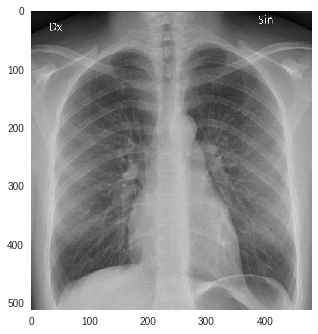

In [0]:
import imageio 
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
image = imageio.imread('chest-xray.jpg', pilmode='L')
print('元画像の解像度: ', image.shape)
image = scipy.ndimage.zoom(image, 0.25)
image = image[0:512, :]
print('縮小後の解像度: ', image.shape)
ax.imshow(image, cmap='gray')
plt.grid(False)
plt.show()

## 畳み込み演算の基本

**畳み込み(Convolution)**とは、画像よりも小さなサイズを持つカーネル（あるいはフィルタ）と呼ばれる行列を用意し、画像の各画素に対してフィルタの中心を重ね、重なった領域全体に渡って画素とフィルタの内積を計算する演算を言います。

例えば、入力画像$x$の第$(i, j)$要素$x_{(i, j)}$に対して、$(2a+1) \times (2b+1)$の大きさを持つカーネル$w$を用いた畳み込みによって出力される$y_{(i, j)}$は次のように表されます。


$y_{i,j}=\sum_{s=-a}^{a} \sum_{t=-b}^{b}w_{(s,t)}x_{(i+sj,j+t)}$

これは、$x_{(i, j)}$を中心の画素として、行方向と列方向にそれぞれ$\pm a, \pm b$ずつ広げた画像中の少領域と、カーネル$w$の内積を$y_{(i,j)}$とすることを意味しています。

---
**注意** : `convolve2d`は以下のサイトからコードを借用していますが、他にも畳み込みの図式的な説明などもありますので参考にしてみて下さい。

参考 : http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html![image.png](attachment:image.png)

**注意** : より<u>厳密な</u>畳み込みの定義では、上式における$x$の添字が$x_{(i-s,j-t)}$となります。実際、深層畳み込みニューラルネットワークの文脈で語られる**畳み込み**は、数学的には**相関**であると指摘されています。

参考 : https://en.wikipedia.org/wiki/Kernel_(image_processing)

参考 : http://tdual.hatenablog.com/entry/2018/05/02/113110



### 畳み込み演算の実装

次の関数`convolve2d`はカーネルのサイズが$3 \times 3$の条件で、この数式の通りに画像に対する畳み込みを行うものになります。

In [0]:
def convolve2d(image, kernel):
    # 厳密な意味のconvolutionを計算する場合には次の一行をコメントアウトして用いる
    # kernel = np.flipud(np.fliplr(kernel))
    
    output = np.zeros_like(image).astype(np.float32)
    
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))   
    image_padded[1:-1, 1:-1] = image
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x, y] = (kernel * image_padded[x:x+3, y:y+3]).sum()        
    return output

以後、サンプル画像とその一部の少領域（以下、パッチ領域と呼びます）にそれぞれ注目し、個々のカーネルを用いた畳み込みによってどのように画像が変換されるのかを確認していきます。

まず、サンプル画像とそのパッチ領域を並べて表示するための関数を用意します。このとき、パッチ領域に対しては画素値に相当する数値を画像の上に重ねて表示させることで、それぞれの計算過程でピクセル値がどう変化するのかを確かめ易くすることとします。また、サンプル画像の上にパッチ領域に対応する部分を赤枠により表示します。

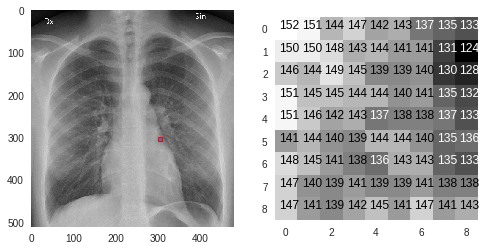

In [0]:
import matplotlib.patches as patches

def show_image_with_patch(image, x=300, y=300, width=9, height=9, vmin=0, vmax=255):
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.grid(False)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor=None)
    ax.add_patch(rect)
    
    if vmin is None:
        vmin = image.min()
    if vmax is None:
        vmax = image.max()
    
    ax.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
   
    ax = fig.add_subplot(122)
    ax.grid(False)
    image_patch = image[x: x + width, y: y + height]
    ax.imshow(image_patch, cmap='gray')
    threshold = (image_patch.max() - image_patch.min()) / 2 + image_patch.min()
    for x in range(width):
        for y in range(height):
            val = int(image_patch[x][y])
            ax.annotate(str(val), 
                        xy=(y - 0.3, x), 
                        color='white' if image_patch[x][y] < threshold else 'black')
    plt.show()
    
show_image_with_patch(image)

### 各種の畳み込み演算の結果

各種の画像変換を行うためのカーネルを定め、実際にそれぞれの畳み込みを当てはめた際にどのように画像が変換されるのかを確かめます。名前のついたカーネルは数多くありますが、次のURLにその代表的なものが紹介されていますので、参考にして下さい。

参考URL : https://en.wikipedia.org/wiki/Kernel_(image_processing)

identity


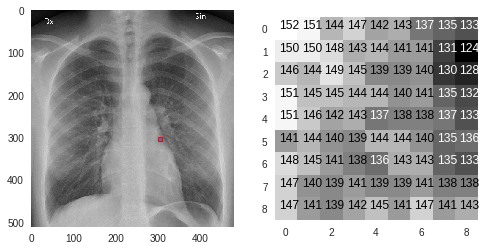

edge detection


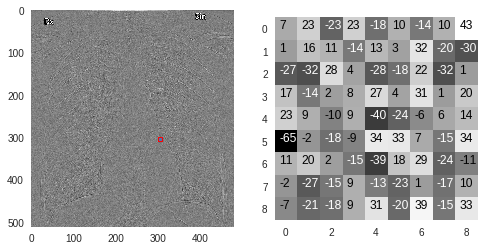

vertical edge detection


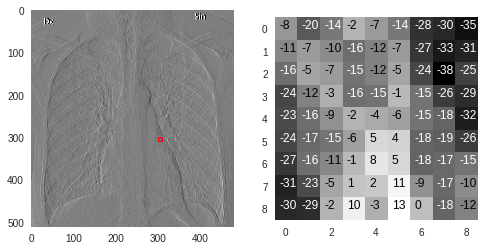

horizontal edge detection


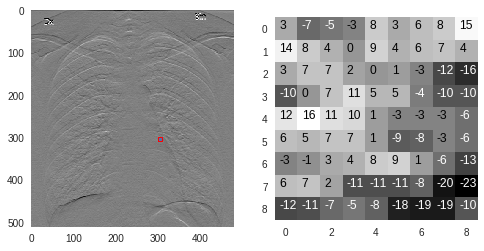

sharpen


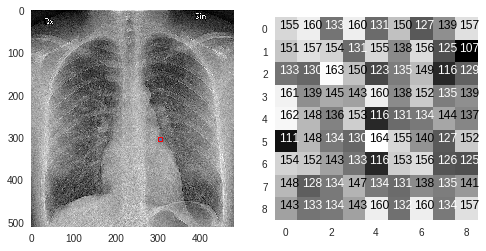

gaussian_blur


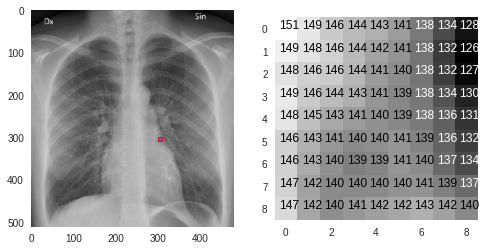

In [0]:
import numpy as np 

print('identity')
identity = np.array([[0, 0, 0], 
                     [0, 1, 0],
                     [0, 0, 0]])

show_image_with_patch(convolve2d(image, identity))

print('edge detection')
edge_detection = np.array([[-1, -1, -1],
                           [-1, 8, -1],
                           [-1, -1, -1]])

show_image_with_patch(convolve2d(image, edge_detection), vmin=-255, vmax=255)

print('vertical edge detection')
vertical = np.array([[-1, 0, 1],
                     [-1, 0, 1],
                     [-1, 0, 1]])

show_image_with_patch(convolve2d(image, vertical), vmin=-255, vmax=255)

print('horizontal edge detection')
horizontal = np.array([[1, 1, 1],
                       [0, 0, 0],
                       [-1, -1, -1]])

show_image_with_patch(convolve2d(image, horizontal), vmin=-255, vmax=255)

print('sharpen')
sharpen = np.array([[0, -1, 0], 
                    [-1, 5, -1],
                    [0, -1, 0]])

show_image_with_patch(convolve2d(image, sharpen), vmin=0, vmax=255)

print('gaussian_blur')
gaussian_blur = np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]]) * (1./16.)

show_image_with_patch(convolve2d(image, gaussian_blur), vmin=0, vmax=255)

以上の結果から、畳み込みによって**エッジの検出**、**先鋭化**、**ぼかし**などの多様な画像変換が可能になることが確認できます。

## 深層畳み込みニューラルネットワークの基礎

深層畳み込みニューラルネットワークは、入力信号に対する畳み込みを行って**特徴マップ**（畳み込み処理後の画像）を出力する**畳み込み層**と、その**特徴マップ**における局所的なパターンを統合する**プーリング層**の組み合わせにより主に構成されます。

前章では、画像に対する古典的な畳み込み演算を概観しました。深層畳み込みニューラルネットワークの**学習**では、ネットワークからの出力と教師信号の誤差を評価する**損失関数**の値を最小化するための方向に、各畳込み層のカーネルの値が**逆誤差伝播法**により学習されます。すなわち、タスクに応じて最適なカーネルが自動的に獲得されるという仕組みを有し、これが<u>「深層学習が人の手によらない特徴抽出を可能にする」</u>と言われる所以です。

---

**注意** : 深層畳み込みニューラルネットワークについての概要については、数多くの分かりやすい説明があるため、適宜ご参考にして下さい。

参考 : https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

### ニューラルネットワークの構築

**VGG16**と呼ばれる深層畳み込みニューラルネットワークを用いて、未学習のネットワークと学習済みのネットワークの内部構造について比較して考察してみたいと思います。

そのために、深層学習ライブラリである**pytorch**と、画像処理のためのライブラリである**torchvision**を利用します。

<u>今回の検討では、このVGG16において各層から抽出される特徴マップを可視化し、サンプル画像がこのネットワークの内部でどのように処理されているのかを考察することとします。</u> そのために、VGG16という名前で定義された`class`を用意し、オリジナルのVGG16の順方向の計算から得た**中間層の特徴マップ**をリストに格納して出力するための関数`forward`を定義します。このとき、プーリング層によって下げられた特徴マップの解像度を、元の解像度に一致させるために`F.interpolate`によるアップサンプリング（解像度を上げる操作）を行います。これにより、入力画像の各ピクセルが特徴マップ中のどの値に対応するかを分かりやすくします。

---

**注意** : 厳密に言えば、`MaxPooling`により選択されなかったピクセルの情報は特徴マップには含まれていないため、`MaxPooling`を逆に遡る働きをする`Unpooling`によりアップサンプリングを行うべきという考え方もあると思います。ここでは単純さを優先し、`MaxPooling`は受容野より代表値を選択する操作であると解釈し、受容野のそれぞれ値はこの代表値を元に復号されても良いとすることとします。

In [0]:
from collections import namedtuple

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import models


class Vgg16(nn.Module):
    def __init__(self, pretrained=False, requires_grad=False):

        super(Vgg16, self).__init__()
        pretrained = models.vgg16(pretrained=pretrained)
        vgg_pretrained_features = pretrained.features

        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()

        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h

        h_relu2_2 = F.interpolate(h_relu2_2, scale_factor=2)
        h_relu3_3 = F.interpolate(h_relu3_3, scale_factor=4)
        h_relu4_3 = F.interpolate(h_relu4_3, scale_factor=8)

        vgg_outputs = namedtuple(
            "VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
        )
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)

        return out



続いて、未学習のVGG16（`scratch`）と、ImageNetと呼ばれるデータセットにおいて学習済みのVGG16（`trained`）を用意します。



In [0]:
scratch = Vgg16(pretrained=False)
trained = Vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [01:07<00:00, 8217508.58it/s]


`scratch`（あるいは`trained`）の`named_parameters`を呼び出すことによって、このネットワークの順方向の計算過程を次のように展開することが出来ます。上の`class`定義中の`forward`関数の中身と見比べながら、以下の太字で示された各階層の最終層の`relu`の出力が、順番にリストに格納されて出力される設計になっていることを確認して下さい。


  (slice1): Sequential(  
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (1): ReLU(inplace)  
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (3): **ReLU(inplace)**  
  )  
  
  (slice2): Sequential(  
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (6): ReLU(inplace)  
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (8): **ReLU(inplace)**  
  )  
  
  (slice3): Sequential(  
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (11): ReLU(inplace)  
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (13): ReLU(inplace)  
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (15): **ReLU(inplace)**  
  )
  
  (slice4): Sequential(  
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (18): ReLU(inplace)  
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (20): ReLU(inplace)  
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    (22): **ReLU(inplace)**  
  )  


### 畳み込み層のカーネルの学習前後での比較

VGG16の最初の畳み込み層（`VGG16.slice1.Conv2d`）におけるカーネルについて、未学習のネットワーク`scratch`と学習済みのネットワーク`trained`とで比較します。出力される図表において、上段が`scratch`より得たカーネル（`s-1, s-2, ..., s-9`）、下段が`trained`より得たカーネル（`t-1, t-2, ..., t-9`）となります。上段のカーネルはどれもがほとんど無構造に見える一方、下段のカーネルの内、例えばt-0やt-5はそれぞれ左右、上下といった方位選択性をもっていることが推察できます。このように、深層畳み込みニューラルネットワークの学習では識別のタスクに対して有用なカーネルが得られていることが推察されます。

---

**注意** : 同様の検討をResNetの最初の$7 \times 7$の畳み込み層のカーネルで行うと、学習に伴うカーネルの構造的な変化がより直感的に分かりやすいかもしれません。

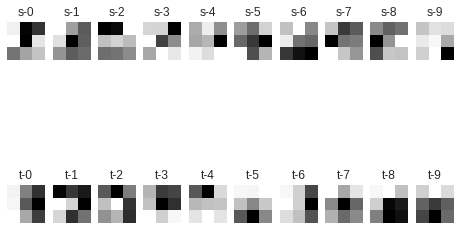

In [0]:
scratch_conv = scratch.slice1[0].weight
trained_conv = trained.slice1[0].weight

fig = plt.figure()

num = 10 
for i in range(num):
    ax = fig.add_subplot(2, num, i+1)
    scratch_img = scratch_conv[i, 0, :, :]
    ax.imshow(scratch_img)
    ax.tick_params(labelbottom=False, bottom=False)
    ax.tick_params(labelleft=False, left=False)
    ax.grid(False)
    ax.set_title('s-' + str(i))
    
    ax = fig.add_subplot(2, num, num + i + 1)
    trained_img = trained_conv[i, 0, :, :]
    ax.imshow(trained_img)
    ax.tick_params(labelbottom=False, bottom=False)
    ax.tick_params(labelleft=False, left=False)
    ax.grid(False)
    ax.set_title('t-' + str(i))

plt.show()

### 画像を入力とした場合のVGG16の中間層の可視化

今回の胸部X線写真を入力画像としてこのVGG16に入力し、順方向の計算（`forward`）で抽出される各中間層の特徴マップを可視化してみます。

**pytorch**ではニューラルネットワークに入力するべき数値列を**torch.Tensor型**に変換して用います。ニューラルネットワークの学習において、損失関数を最小化する方向に修正される変数を**パラメータ**と言いますが、torch.Tensor型ではそれぞれのパラメータが取り得る値に加え、**逆誤差伝播法**によって求められるパラメータの**勾配**の情報を含む**計算グラフ**を保存することが出来ます。

今回の本題とは逸れますが、**計算グラフ**の概念は深層学習の計算手続きを理解する上で非常に重要ですので、例えば次のようなURLを参照して下さい。

参考 : https://www.slideshare.net/unnonouno/chainer-59664785

---

**注意** : torch.Tensor型が計算グラフを直接保持する機能を有するのはpytorchのバージョン0.4以降であることに注意して下さい。

ここから先は計算にGPUを利用するため、まずは環境をチェックします。次のコードの実行でエラーが出た場合は、Google colabのランタイムの環境でGPUの利用がチェックされているかどうかを確かめて下さい。また、Google colab上でのGPUの使用率をチェックする関数を定義しておきます。

In [0]:
assert torch.cuda.is_available() == True

続いて、今回のサンプル画像についてNumPy配列からtorch.Tensor型に変換し（`numpy_to_tensor`）、VGG16の`forward`関数でこれを計算することにより中間層の特徴マップを取り出します。

---

**注意** : 今回の検討ではあくまでもニューラルネットワークの順方向の計算結果のみ必要であり、誤差逆伝播法で必要とされる計算グラフは不要になります。そこで、ニューラルネットワークによる計算時には`torch.no_grad()`というコンテクストマネージャーを使用します。これにより、計算グラフを構築することによる負荷を除いた処理を行うことが出来ます。

In [0]:
from torchvision import transforms

def numpy_to_tensor(x):
  normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
  )
  
  x = x[np.newaxis, ...]
  x = np.repeat(x, 3, 0)
  x = torch.from_numpy(x).float()
  x = normalize(x).unsqueeze(0)
  return x


x = numpy_to_tensor(image).cuda()

scratch.cuda().eval()
trained.cuda().eval()

with torch.no_grad():
    features_scratch = scratch(x)
    features_trained = trained(x)
    
    for attr in ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']:
        print(attr)
        print('scratch: ', getattr(features_scratch, attr).shape)
        print('trained: ', getattr(features_trained, attr).shape)
        
        
torch.cuda.empty_cache()

relu1_2
scratch:  torch.Size([1, 64, 512, 480])
trained:  torch.Size([1, 64, 512, 480])
relu2_2
scratch:  torch.Size([1, 128, 512, 480])
trained:  torch.Size([1, 128, 512, 480])
relu3_3
scratch:  torch.Size([1, 256, 512, 480])
trained:  torch.Size([1, 256, 512, 480])
relu4_3
scratch:  torch.Size([1, 512, 512, 480])
trained:  torch.Size([1, 512, 512, 480])


上記の計算により、中間層の特徴マップ（`relu1_2, relu2_2, relu3_3, relu4_3`）の数が順番に64, 128, 256, 512となっていることが分かります。尚、この同一階層中の特徴マップの数は**チャンネル数**と呼ばれます。

続いて、`scratch`と`trained`の中間層の特徴マップを5枚ずつ並べて表示することにより、その違いについて確認します。

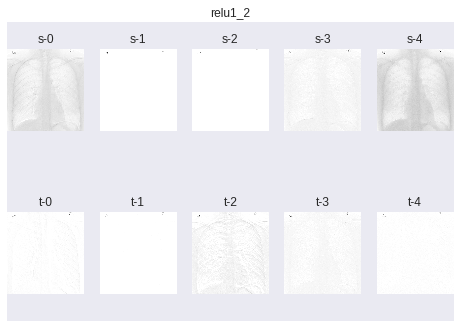

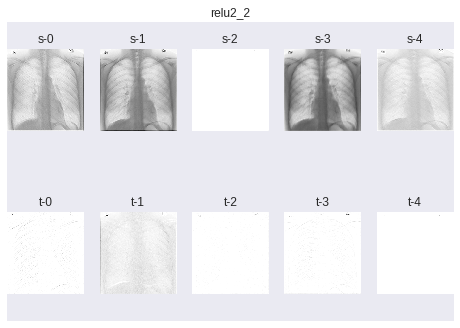

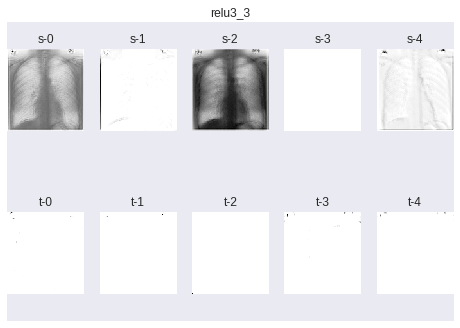

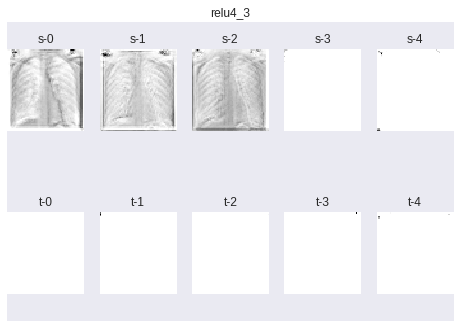

In [0]:
def compare_feature_maps(feat_scratch, feat_trained, num=5, title=None):
    
    fig = plt.figure()
    
    if title:
        plt.title(title)
        
    plt.tick_params(labelbottom=False, bottom=False)
    plt.tick_params(labelleft=False, left=False)
    plt.grid(False)    
    
    for i in range(num):
        ax = fig.add_subplot(2, num, i + 1)
        scratch_img = feat_scratch[0, i, :, :]
        ax.imshow(scratch_img)
        ax.tick_params(labelbottom=False, bottom=False)
        ax.tick_params(labelleft=False, left=False)
        ax.grid(False)
        ax.set_title('s-' + str(i))
        
        ax = fig.add_subplot(2, num, num + i + 1)
        trained_img = feat_trained[0, i, :, :]
        ax.imshow(trained_img)
        ax.tick_params(labelbottom=False, bottom=False)
        ax.tick_params(labelleft=False, left=False)
        ax.grid(False)
        ax.set_title('t-' + str(i))
        
    plt.show()
    
    
for attr in ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']:
    feat_scratch = getattr(features_scratch, attr)
    feat_trained = getattr(features_trained, attr)
    
    feat_scratch = feat_scratch.detach().cpu().numpy()
    feat_trained = feat_trained.detach().cpu().numpy()
    
    compare_feature_maps(feat_scratch, feat_trained, title=attr)

### 特徴マップのクラスタリングによるセグメンテーション

単純な可視化だけでは、学習によってどの程度「意味のある」特徴マップが抽出されたのかを見て取ることが困難でした。

そこで、入力画像の各ピクセルを、対応する特徴マップの同一の位置にある値により構成されるベクトル（`64 + 128 + 256 + 512 = 960次元`）として表すこととします。続いて、それぞれ960次元のベクトルで表される画像中の全てのピクセルを、そのベクトル表現に基づいて**k-近傍法**によりクラスタリングします。最終的に、割り当てられたクラスタ毎にピクセルを分類し、色付けすることによって特徴マップによってどの程度の粒度の情報が得られているのかを考察します。

---

k-近傍法についての参考URL : https://ja.wikipedia.org/wiki/K%E8%BF%91%E5%82%8D%E6%B3%95

まず、次の処理によって入力画像のピクセル毎に中間層の特徴マップの値を取得し、960次元のベクトルとして構成します。

In [0]:
stacked_feat_scratch = None 
stacked_feat_trained = None 

for attr in ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']:
    feat_scratch = getattr(features_scratch, attr)
    feat_trained = getattr(features_trained, attr)
    
    feat_scratch = feat_scratch.detach().cpu().numpy().astype(np.float16)
    feat_trained = feat_trained.detach().cpu().numpy().astype(np.float16)
    
    if stacked_feat_scratch is None:
        stacked_feat_scratch = feat_scratch 
    else:
        stacked_feat_scratch = np.concatenate((stacked_feat_scratch, feat_scratch), axis=1) 
       
    if stacked_feat_trained is None:
        stacked_feat_trained = feat_trained 
    else: 
        stacked_feat_trained = np.concatenate((stacked_feat_trained, feat_trained), axis=1) 
        
stacked_feat_scratch = stacked_feat_scratch[0, ...].reshape(960, 512 * 480).transpose(1, 0)
stacked_feat_trained = stacked_feat_trained[0, ...].reshape(960, 512 * 480).transpose(1, 0)
        
print('stacked_feat_scratch: ', stacked_feat_scratch.shape)
print('stacked_feat_trained: ', stacked_feat_trained.shape)

stacked_feat_scratch:  (245760, 960)
stacked_feat_trained:  (245760, 960)


続いて、未学習のネットワークである`scratch`から得た特徴マップの値に基づいたクラスタリングを行います。

In [0]:
from sklearn.cluster import KMeans

kmeans_scratch = KMeans(init='k-means++', n_clusters=8, n_init=10)
kmeans_scratch.fit(stacked_feat_scratch)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

同様に、学習済みのネットワークである`trained`から得た特徴マップの値に基づいたクラスタリングを行います。

In [0]:
from sklearn.cluster import KMeans

kmeans_trained = KMeans(init='k-means++', n_clusters=8, n_init=10)
kmeans_trained.fit(stacked_feat_trained)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

最後に、それぞれのクラスタリングの結果を入力画像と並べて表示させます。

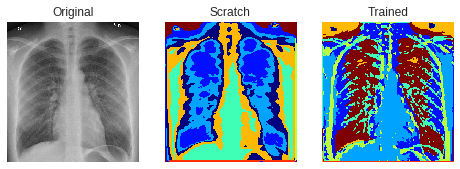

In [0]:
labels_scratch = kmeans_scratch.labels_.reshape(512, 480)
labels_trained = kmeans_trained.labels_.reshape(512, 480)

fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
ax.imshow(image, cmap='gray')
ax.tick_params(labelbottom=False, bottom=False)
ax.tick_params(labelleft=False, left=False)
ax.grid(False)
ax.set_title('Original')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(labels_scratch, cmap='jet')
ax.tick_params(labelbottom=False, bottom=False)
ax.tick_params(labelleft=False, left=False)
ax.grid(False)
ax.set_title('Scratch')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(labels_trained, cmap='jet')
ax.tick_params(labelbottom=False, bottom=False)
ax.tick_params(labelleft=False, left=False)
ax.grid(False)
ax.set_title('Trained')

plt.show()

結果として、`scratch`より得たセグメンテーションでも一定の解剖学的な構造が抽出されている点が興味深く感じられます。これは、ランダムな重みであっても、深層畳み込みニューラルネットワークの出力から大まかなセグメンテーションが得られるという先行研究（参考）とも合致します。一方、ImageNetによる学習を経た`trained`の出力からは、肋骨や胸壁などのより細かい構造が抽出されていることが見てとれます。すなわち、深層畳み込みニューラルネットワークの学習によって、解剖学的により微細な構造を抽出できるような特徴マップが得られていることが分かります。

---

参考 : https://arxiv.org/abs/1807.05520